In [1]:
import sys
import os

os.chdir("..")
os.getcwd()

'/Users/laurasisson/dream'

In [2]:
os.listdir()

['dreamdata.py',
 'aggregate.py',
 'cross.py',
 '.DS_Store',
 'embedding.py',
 'crossoverlap.py',
 'dictionary.pt',
 'olfactor.py',
 'mpnn.py',
 'encoder.py',
 'README.md',
 'tokenizer.py',
 'activation.py',
 '.gitignore',
 'utils.py',
 'Model',
 'Colab',
 '.git',
 'Data',
 'Notebooks',
 'pairdata.py',
 'data.py']

In [3]:
import json

with open("Data/full_large.json") as f:
    pair_dataset = json.load(f)

pair_dataset = [d for d in pair_dataset if d["mol1"] and d["mol2"]]

len(pair_dataset), pair_dataset[0]

(266758,
 {'mol1': 'CC1=CC2C(C2(C)C)CC1C(=O)C',
  'mol2': 'CCCC(CC)O',
  'blend_notes': ['herbal']})

In [4]:
import collections

all_notes_sets = collections.defaultdict(list)
all_mols = set()
for d in pair_dataset:
    if not "citrus" in d["blend_notes"]:
        continue
    all_notes_sets[frozenset(d["blend_notes"])].append({d["mol1"], d["mol2"]})
    all_mols.add(d["mol1"])
    all_mols.add(d["mol2"])

ex_notes, ex_blends = next(iter(all_notes_sets.items()))
all_mols = list(all_mols)
len(all_notes_sets), len(all_mols), ex_notes, len(ex_blends)

(489, 2187, frozenset({'citrus'}), 2641)

In [5]:
all_recipes = list(all_notes_sets.values())
total_combination_count = len(all_recipes)
len(all_recipes), len(all_recipes[0]), all_recipes[0][0]

(489, 2641, {'CC(CCC=C(C)C)CC#N', 'CCCCCCCCCCCCCCC(=O)O'})

In [6]:
len(all_notes_sets.keys())

489

In [7]:
import collections

idx_to_recipe = dict()


def precompute_ingredient_indices(sample_recipes):
    """Precompute which recipes each ingredient can cover."""
    ingredient_indices = nested_dict = collections.defaultdict(
        lambda: collections.defaultdict(set)
    )
    current_recipe_idx = 0

    # The combination is the underlying set of descriptors.
    for combination_idx, recipes in enumerate(sample_recipes):
        # The recipe is one particular pairing that results in that combination.
        for recipe in recipes:
            for ingredient in recipe:
                ingredient_indices[ingredient][combination_idx].add(current_recipe_idx)
                idx_to_recipe[current_recipe_idx] = recipe
                current_recipe_idx += 1

    return ingredient_indices, current_recipe_idx


all_ingredient_indices, total_recipe_count = precompute_ingredient_indices(all_recipes)
total_recipe_count, next(iter(all_ingredient_indices.items()))

(21965,
 ('CC(CCC=C(C)C)CC#N',
  defaultdict(set,
              {0: {0,
                30,
                64,
                182,
                240,
                308,
                320,
                396,
                462,
                514,
                572,
                606,
                632,
                650,
                758,
                878,
                1065,
                1223,
                1281,
                1359,
                1377,
                1421,
                1425,
                1545,
                1567,
                1687,
                1713,
                1721,
                1795,
                1845,
                1917,
                1933,
                1977,
                2045,
                2183,
                2387,
                2423,
                2437,
                2501,
                2573,
                2589,
                2663,
                2673,
                2711,

In [8]:
import numpy as np
import random


class Solution:
    def __init__(self, ingredients=None, coverage_bitmask=None, total_covered=0):
        self._ingredients = ingredients if ingredients is not None else frozenset()
        # coverage_bitmask now tracks combinations, not recipes
        self.coverage_bitmask = (
            coverage_bitmask
            if coverage_bitmask is not None
            else np.zeros(len(all_recipes), dtype=bool)
        )
        self.total_covered = total_covered

    @classmethod
    def random_solution(cls, n):
        # If n matches the total number of ingredients, use all_mols directly
        if n == len(all_mols):
            selected_ingredients = frozenset(all_mols)
        else:
            # Otherwise, select n unique ingredients from all_mols
            selected_ingredients = frozenset(random.sample(all_mols, n))

        # Initialize the coverage bitmask for combinations
        coverage_bitmask = np.zeros(len(all_recipes), dtype=bool)
        total_covered = 0

        # Check each combination and mark it as covered if any of its recipes is fully satisfied
        for combination_idx, recipes in enumerate(all_recipes):
            for recipe in recipes:
                if set(recipe) <= selected_ingredients:
                    coverage_bitmask[combination_idx] = True
                    total_covered += 1
                    break  # Stop once the combination is covered by any recipe

        # Create the solution instance
        solution = cls(selected_ingredients, coverage_bitmask, total_covered)

        # Validation check: if we selected all ingredients, every combination should be covered
        if n == len(all_mols):
            assert solution.total_covered == len(
                all_recipes
            ), "Expected full coverage of all combinations, but got partial coverage."

        return solution

    def add(self, ingredient):
        assert ingredient not in self._ingredients
        new_ingredients = self._ingredients | frozenset([ingredient])
        new_coverage_bitmask = self.coverage_bitmask.copy()
        new_total_covered = self.total_covered

        ingredient_index = all_ingredient_indices[ingredient]

        for combination_idx, recipe_indices in ingredient_index.items():
            if not new_coverage_bitmask[
                combination_idx
            ]:  # Only check if not already covered
                for recipe_idx in recipe_indices:
                    recipe_ingredients = set(idx_to_recipe[recipe_idx])
                    if recipe_ingredients <= new_ingredients:
                        new_coverage_bitmask[combination_idx] = True
                        new_total_covered += 1
                        break  # Stop once the combination is covered

        return Solution(new_ingredients, new_coverage_bitmask, new_total_covered)

    def remove(self, ingredient):
        assert ingredient in self._ingredients
        new_ingredients = self._ingredients - frozenset([ingredient])
        new_coverage_bitmask = self.coverage_bitmask.copy()
        new_total_covered = self.total_covered

        ingredient_index = all_ingredient_indices[ingredient]

        for combination_idx, recipe_indices in ingredient_index.items():
            if self.coverage_bitmask[
                combination_idx
            ]:  # Only adjust if currently covered
                # Check if removing this ingredient uncovers the combination
                still_covered = False
                for recipe_idx in recipe_indices:
                    recipe_ingredients = set(idx_to_recipe[recipe_idx])
                    if recipe_ingredients <= new_ingredients:
                        still_covered = True
                        break  # Combination is still covered by another recipe

                if not still_covered:
                    new_coverage_bitmask[combination_idx] = False
                    new_total_covered -= 1

        return Solution(new_ingredients, new_coverage_bitmask, new_total_covered)

    def __contains__(self, ingredient):
        return ingredient in self._ingredients

    def __len__(self):
        return len(self._ingredients)

    def coverage(self):
        return self.total_covered

    def __repr__(self):
        return (
            f"Solution of size {len(self._ingredients)} w/ coverage {self.coverage()}"
        )


# Example usage of random solution creation with full coverage check
random_solution = Solution.random_solution(len(all_mols))
display(random_solution)

Solution of size 2187 w/ coverage 489

Random Solution:   0%|          | 0/105 [00:00<?, ?it/s]

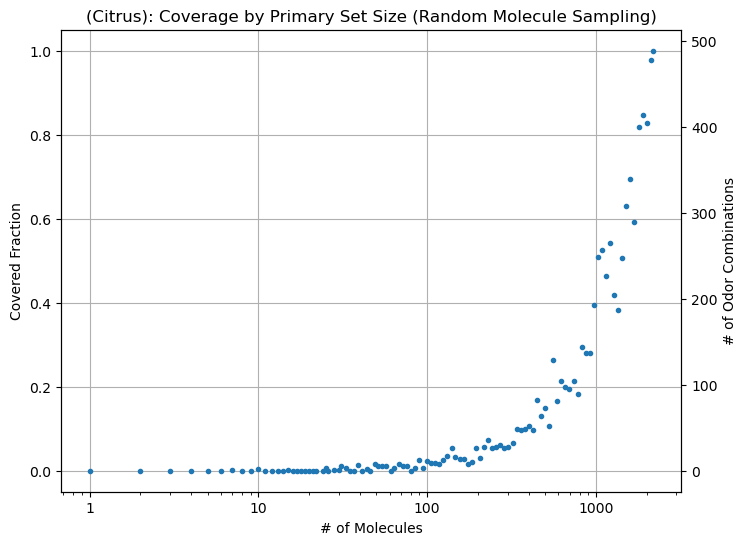

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from tqdm.notebook import tqdm
import re


x = np.logspace(0, 6, 250)  # Exponential range from 10^0 to 10^4 (1 to 1e4)
x_int = np.unique(
    np.round(x).astype(int)
)  # Round and convert to integer, then keep unique values
x_int = x_int[x_int < len(all_mols)]
x_int = np.append(x_int, len(all_mols))

random_passes = 1

random_fraction_at_x = []
pbar = tqdm(total=len(x_int), desc="Random Solution", leave=True, smoothing=1)
for max_ingredients in x_int:
    coverage = []
    for _ in range(random_passes):
        random_solution = Solution.random_solution(max_ingredients)
        random_coverage = random_solution.coverage()
        coverage.append(random_coverage)

    fraction = np.mean(coverage) / total_combination_count
    pbar.set_postfix(
        {"Blend Size": max_ingredients, "Fraction Covered": f"{fraction:.4f}"}
    )
    pbar.update(1)
    random_fraction_at_x.append(fraction)


def make_chart(fraction_at_x, title):
    def clean_title_for_filename(title):
        # Remove special characters and replace spaces with underscores
        filename = re.sub(
            r"[^\w\s]", "", title
        )  # Remove non-alphanumeric characters except spaces
        filename = re.sub(r"\s+", "_", filename)  # Replace spaces with underscores
        return filename.lower()

    title = f"(Citrus): {title}"
    # Plot the data points on the primary axis
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x_int[: len(fraction_at_x)], fraction_at_x, marker=".", linestyle="")
    ax1.set_xscale("log")  # Set x-axis to log scale

    # Format the x-axis log scale to show numbers without scientific notation
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    ax1.grid()

    # Primary axis labels and title
    ax1.set_title(title)
    ax1.set_xlabel("# of Molecules")
    ax1.set_ylabel("Covered Fraction")

    # Add twin y-axis, scaled version without plotting points again
    ax2 = ax1.twinx()
    scale_factor = len(all_notes_sets)
    ax2.set_ylim(ax1.get_ylim()[0] * scale_factor, ax1.get_ylim()[1] * scale_factor)
    ax2.set_ylabel("# of Odor Combinations")

    # Show the plot
    plt.savefig(os.path.join("Notebooks/Charts", clean_title_for_filename(title)))
    plt.show()


make_chart(
    random_fraction_at_x, "Coverage by Primary Set Size (Random Molecule Sampling)"
)

In [10]:
greedy_cache = dict()


# Greedy solution with caching
def greedy_coverage(max_ingredients, use_cache=True, disable_tqdm=False):
    global greedy_cache

    current_solution = Solution()

    # Initialize progress bar
    pbar = tqdm(
        total=max_ingredients, desc="Greedy Solution", leave=True, disable=disable_tqdm
    )

    for size in range(max_ingredients):
        if size in greedy_cache and use_cache:
            current_solution = greedy_cache[size]
            pbar.set_postfix(
                {
                    "Fraction Covered": f"{current_solution.coverage() / total_combination_count:.4f}"
                }
            )
            pbar.update(1)
            continue

        # Initialize best solution for this round as the current solution
        best_solution = current_solution
        current_coverage = current_solution.coverage()

        for mol in all_mols:
            # Check only ingredients not already in the solution
            if mol in current_solution:
                continue

            # Calculate coverage with the new molecule
            greedy_solution = current_solution.add(mol)
            if greedy_solution.coverage() > current_coverage:
                best_solution = greedy_solution
                current_coverage = greedy_solution.coverage()

        # Update our results and cache
        current_solution = best_solution
        greedy_cache[size] = current_solution

        # Update the progress bar
        pbar.set_postfix(
            {
                "Fraction Covered": f"{current_solution.coverage() / total_combination_count:.4f}"
            }
        )
        pbar.update(1)

    pbar.close()
    return current_solution


# Test the caching with a small run
_ = greedy_coverage(max_ingredients=50)

# Run a larger greedy solution
best_solution = greedy_coverage(max_ingredients=100)
print(f"Random Start Solution: {best_solution}")
print(f"Max Recipes Covered: {best_solution.coverage()}")
print(
    f"Fraction of Recipes Covered: {best_solution.coverage() / total_combination_count:.4f}"
)

Greedy Solution:   0%|          | 0/50 [00:00<?, ?it/s]

Greedy Solution:   0%|          | 0/100 [00:00<?, ?it/s]

Random Start Solution: Solution of size 100 w/ coverage 249
Max Recipes Covered: 249
Fraction of Recipes Covered: 0.5092


Greedy Solution:   0%|          | 0/105 [00:00<?, ?it/s]

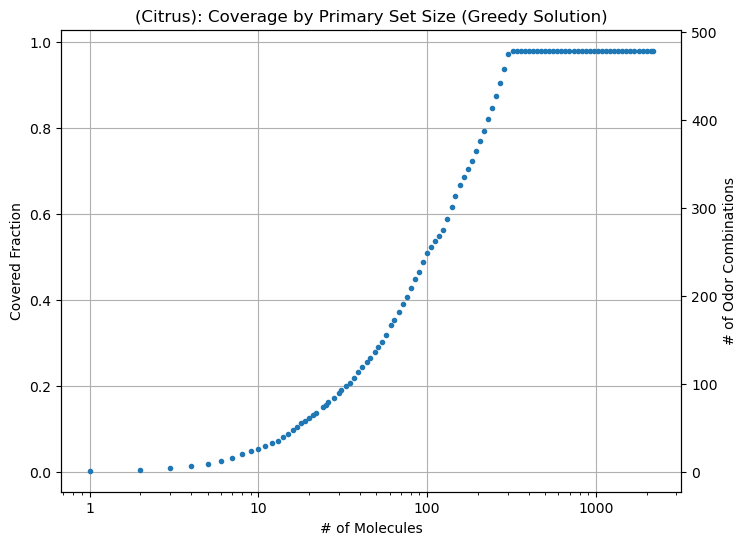

In [11]:
pbar = tqdm(total=len(x_int), desc="Greedy Solution", leave=True, smoothing=1)

greedy_fraction_at_x = []
for max_ingredients in x_int:
    best_solution = greedy_coverage(
        max_ingredients=max_ingredients, use_cache=True, disable_tqdm=True
    )
    pbar.set_postfix(
        {
            "Blend Size": max_ingredients,
            "Fraction Covered": f"{best_solution.coverage() / total_combination_count:.4f}",
        }
    )
    pbar.update(1)
    greedy_fraction_at_x.append(best_solution.coverage() / total_combination_count)

make_chart(greedy_fraction_at_x, "Coverage by Primary Set Size (Greedy Solution)")

In [12]:
import math


def simulated_annealing_max_coverage(
    max_ingredients,
    start_random=True,
    initial_temp=100,
    cooling_rate=0.99,
    num_iterations=10000,
    disable_tqdm=False,
):
    """Simulated annealing to find the best set of ingredients that maximizes recipe coverage."""

    total_recipes = len(all_recipes)

    if start_random:
        current_solution = Solution.random_solution(max_ingredients)
    else:
        current_solution = greedy_coverage(
            max_ingredients=max_ingredients, use_cache=True, disable_tqdm=True
        )

    # Track the best solution
    best_solution = current_solution

    temp = initial_temp

    # Initialize progress bar
    pbar = tqdm(
        total=num_iterations,
        desc="Simulated Annealing",
        leave=True,
        disable=disable_tqdm,
    )

    for i in range(num_iterations):
        # Generate a new solution by swapping one ingredient
        new_solution = current_solution

        # If we're at the max ingredients, ensure we don't exceed it
        if len(new_solution) >= max_ingredients:
            # Randomly remove an ingredient before adding a new one
            ingredient_to_remove = random.choice(list(new_solution._ingredients))
            new_solution = new_solution.remove(ingredient_to_remove)

        # Add a new ingredient from the pool of unused ingredients
        available_ingredients = [i for i in all_mols if i not in new_solution]
        if available_ingredients:
            ingredient_to_add = random.choice(available_ingredients)
            new_solution = new_solution.add(ingredient_to_add)

        # Calculate acceptance probability
        if new_solution.coverage() > current_solution.coverage():
            accept = True  # Always accept a better solution
        else:
            delta = current_solution.coverage() - new_solution.coverage()
            accept_probability = math.exp(-delta / temp)
            accept = (
                random.random() < accept_probability
            )  # Accept worse solution with some probability

        # Accept the new solution
        if accept:
            current_solution = new_solution

            # Update the best solution if the new solution is better
            if current_solution.coverage() > best_solution.coverage():
                best_solution = current_solution

        # Cool down the temperature
        temp *= cooling_rate

        # Update the progress bar and show the fraction of recipes covered
        pbar.set_postfix(
            {
                "Fraction Covered": f"{current_solution.coverage() / total_recipes:.4f}",
                "Temperature": f"{temp:.2f}",
            }
        )
        pbar.update(1)

    pbar.close()

    return best_solution


best_solution = simulated_annealing_max_coverage(
    max_ingredients=100, initial_temp=1e4, disable_tqdm=True
)
print(f"Random Start Solution: {best_solution}")
print(f"Max Recipes Covered: {best_solution.coverage()}")
print(f"Fraction of Recipes Covered: {best_solution.coverage() / len(all_recipes):.4f}")

Random Start Solution: Solution of size 100 w/ coverage 121
Max Recipes Covered: 121
Fraction of Recipes Covered: 0.2474


Simulated Annealing:   0%|          | 0/105 [00:00<?, ?it/s]

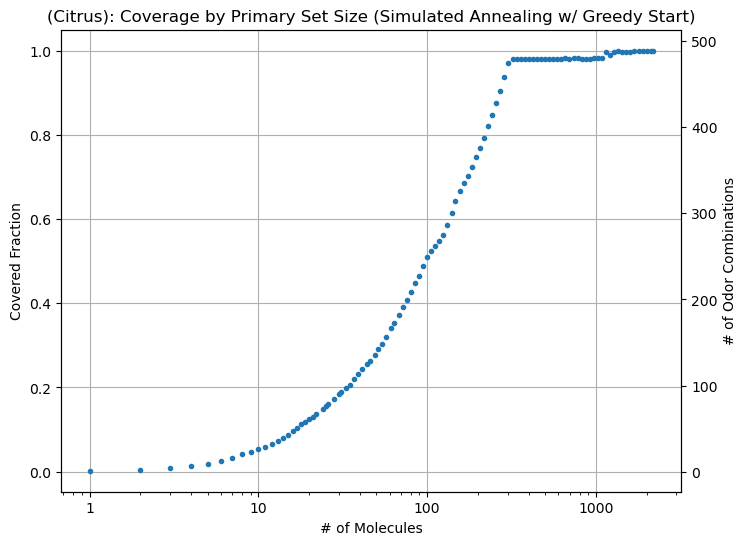

In [13]:
pbar = tqdm(total=len(x_int), desc="Simulated Annealing", leave=True, smoothing=1)

greedy_annealed_fraction_at_x = []
for max_ingredients in x_int:
    best_solution = simulated_annealing_max_coverage(
        max_ingredients=max_ingredients,
        start_random=False,
        num_iterations=int(5e4),
        initial_temp=1e3,
        disable_tqdm=True,
    )
    pbar.set_postfix(
        {
            "Blend Size": max_ingredients,
            "Fraction Covered": f"{best_solution.coverage()/len(all_recipes):.4f}",
        }
    )
    pbar.update(1)
    greedy_annealed_fraction_at_x.append(best_solution.coverage() / len(all_recipes))

make_chart(
    greedy_annealed_fraction_at_x,
    "Coverage by Primary Set Size (Simulated Annealing w/ Greedy Start)",
)

Simulated Annealing:   0%|          | 0/105 [00:00<?, ?it/s]

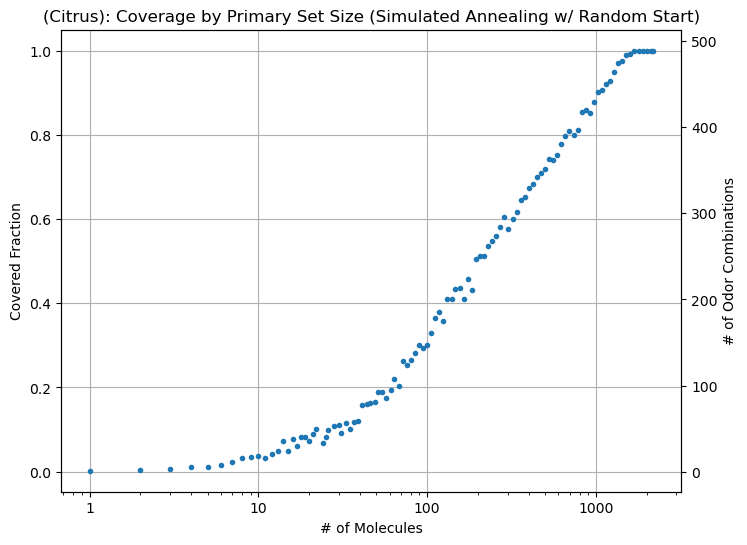

In [14]:
pbar = tqdm(total=len(x_int), desc="Simulated Annealing", leave=True, smoothing=1)

annealed_fraction_at_x = []
for max_ingredients in x_int:
    best_solution = simulated_annealing_max_coverage(
        max_ingredients=max_ingredients,
        num_iterations=int(5e4),
        initial_temp=1e3,
        disable_tqdm=True,
    )
    pbar.set_postfix(
        {
            "Blend Size": max_ingredients,
            "Fraction Covered": f"{best_solution.coverage()/len(all_recipes):.4f}",
        }
    )
    pbar.update(1)
    annealed_fraction_at_x.append(best_solution.coverage() / len(all_recipes))

make_chart(
    annealed_fraction_at_x,
    "Coverage by Primary Set Size (Simulated Annealing w/ Random Start)",
)